---
## Lidar data
First step is to install the Laspy library, wich is used to read data from one of the tiles file.

In [ ]:
  !pip install laspy

     |████████████████████████████████| 596 kB 557 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for laspy: filename=laspy-2.0.2-py3-none-any.whl size=49994 sha256=f60bd5736d4c5ac86226b283a8788db8ec78aea82a8eae75e53ffe79c79ceb50
  Stored in directory: /root/.cache/pip/wheels/42/76/f3/21f76ecfbe80f0fe5d16b32686302770120788f25f937c6a56
Successfully built laspy


You need upload the file to your drive and copy the path to substitute the one in the code.

The examples are hard-coded, as they depend on visual inspection, but feel free to run with another tile - I hope it will work



In [ ]:
import laspy
lidar = laspy.read("/content/drive/MyDrive/HACKATHON/Known_Damage_Tiles/X161_Y113.las")

---
## Buildings footprints
We install the Geopandas library, wich is used to read the data of the buildins footprint.

In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.6 MB 31.3 MB/s 


Again, you need to upload the data and copy the path.

The data is available at: https://data.humdata.org/dataset/hotosm_pri_buildings

In [ ]:
import geopandas as gpd
shapefile = gpd.read_file("/content/drive/MyDrive/HACKATHON/hotosm_pri_buildings_polygons_shp/hotosm_pri_buildings_polygons.shp")

We will see what is inside that file

In [ ]:
shapefile.head()

,osm_id,source,building,buildingma,buildingle,addrstreet,addrcity,addrhousen,addrfull,office,name,geometry
0,20885732.0,None,yes,None,None,None,None,None,None,None,Multipisos UPRRP,"POLYGON ((-66.04457 18.40265, -66.04374 18.402..."
1,20887004.0,None,university,None,None,None,None,None,None,None,Escuela de Arquitecura y Escuela de Bellas Artes,"POLYGON ((-66.04640 18.40216, -66.04640 18.402..."
2,20887047.0,None,university,None,None,None,None,None,None,None,Anexo Lic. Eugenio María de Hostos,"POLYGON ((-66.04833 18.40213, -66.04831 18.402..."
3,20887143.0,None,university,None,None,None,None,None,None,None,Teatro UPR,"POLYGON ((-66.04906 18.40255, -66.04903 18.402..."
4,20887609.0,None,school,None,None,None,None,None,None,None,Complejo Deportivo Cosme Beitía Sálamo,"POLYGON ((-66.04705 18.40773, -66.04624 18.407..."


For now, we will focus on the geometry.

We can compare the data with [Google Maps](https://www.google.com.br/maps/place/18%C2%B024'08.2%22N+66%C2%B002'52.6%22W/@18.4022494,-66.0489189,387m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d18.40229!4d-66.04794)

X:-66.04794307461428
Y:18.402293525879216



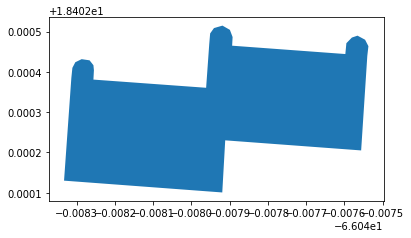

In [ ]:
buildings = shapefile.geometry
buildings[2:3].plot()
centroid = buildings[2:3].to_crs(32161).centroid.to_crs(4326)
print(f'X:{centroid[2].x}\nY:{centroid[2].y}\n')

We create a Polygon that represents where the Lidar data is located on Earth

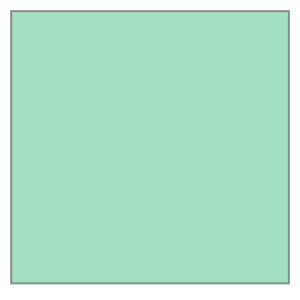

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
lidar_space = Polygon([(np.max(lidar.x), np.max(lidar.y)), (np.max(lidar.x), np.min(lidar.y)), (np.min(lidar.x), np.min(lidar.y)), (np.min(lidar.x), np.max(lidar.y))])
lidar_space

In [ ]:
lidar_space.centroid.x

254530.62499999997

We convert the Coordinate Reference system of the buildings data to [EPSG 32161](https://epsg.io/32161) and perform the intersection operation

In [ ]:
buildings = buildings.to_crs(32161)

In [ ]:
buildings = buildings.intersection(lidar_space)

In [ ]:
builds_on_data = buildings[(buildings.is_empty)==False]

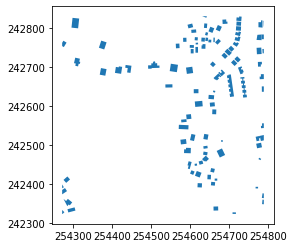

In [ ]:
builds_on_data.plot()

[NOAA Imagery of this region](https://storms.ngs.noaa.gov/storms/maria/index.html#17/18.21733/-65.91779)

The next step is to convert the Point Cloud data to Points object from the Shapely library

In [ ]:
coords = np.vstack((lidar.x, lidar.y)).transpose()
coords

array([[254343.6 , 242666.38],
       [254343.6 , 242666.38],
       [254343.6 , 242666.64],
       ...,
       [254444.19, 242416.2 ],
       [254444.11, 242416.51],
       [254444.22, 242416.49]])

In [ ]:
from shapely.geometry import Point
geopoints = gpd.GeoDataFrame(coords[:], columns=['x', 'y'])
#geopoints.apply(lambda x: Point(x))
geopoints['point'] = geopoints.apply(lambda i:Point(i.x, i.y), axis=1)
geopoints

,x,y,point
0,254343.60,242666.38,POINT (254343.6 242666.38)
1,254343.60,242666.38,POINT (254343.6 242666.38)
2,254343.60,242666.64,POINT (254343.6 242666.64)
3,254343.59,242666.64,POINT (254343.59 242666.64)
4,254343.59,242666.91,POINT (254343.59 242666.91)
...,...,...,...
5876344,254444.06,242416.30,POINT (254444.06 242416.3)
5876345,254444.20,242416.22,POINT (254444.2 242416.22)
5876346,254444.19,242416.20,POINT (254444.19 242416.2)
5876347,254444.11,242416.51,POINT (254444.11 242416.51)


In [ ]:
geopoints

,x,y,point
0,254343.60,242666.38,POINT (254343.6 242666.38)
1,254343.60,242666.38,POINT (254343.6 242666.38)
2,254343.60,242666.64,POINT (254343.6 242666.64)
3,254343.59,242666.64,POINT (254343.59 242666.64)
4,254343.59,242666.91,POINT (254343.59 242666.91)
...,...,...,...
5876344,254444.06,242416.30,POINT (254444.06 242416.3)
5876345,254444.20,242416.22,POINT (254444.2 242416.22)
5876346,254444.19,242416.20,POINT (254444.19 242416.2)
5876347,254444.11,242416.51,POINT (254444.11 242416.51)


In [ ]:
geogeopoints = gpd.GeoSeries(geopoints.point)

Next step is to select the points that correspond to the undamaged and the damaged building.

In [ ]:
mask = np.array(geogeopoints.within(builds_on_data[442544]))
build1_pt = lidar[mask]

In [ ]:
mask = np.array(geogeopoints.within(builds_on_data[685650]))
build2_pt = lidar[mask]

Then, experiment with some different plots



Text(0.5, 0, 'Intensity')

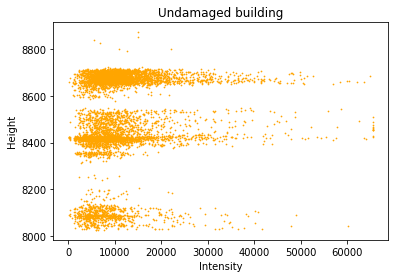

In [ ]:
plt.scatter(build1_pt.intensity, build1_pt.Z, c='orange', s=0.5)
plt.title("Undamaged building")
plt.ylabel("Height")
plt.xlabel("Intensity")

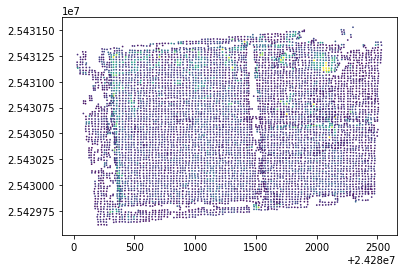

In [ ]:
plt.scatter(build1_pt.Y, build1_pt.X, c=build1_pt.intensity , s=0.5)

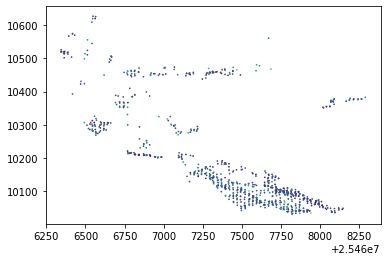

In [ ]:
plt.scatter(build2_pt.X, build2_pt.Z, c=build2_pt.intensity , s=0.5)

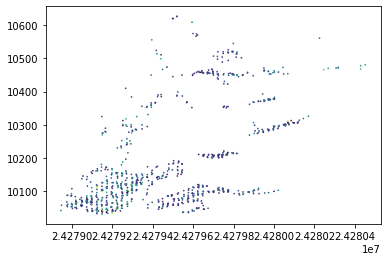

In [ ]:
plt.scatter(build2_pt.Y, build2_pt.Z, c=build2_pt.intensity , s=0.5)

Text(0.5, 0, 'X')

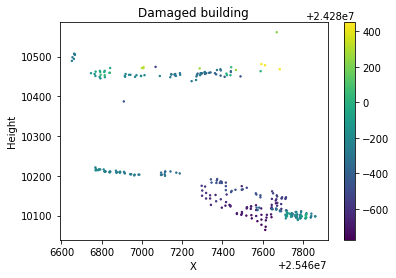

In [ ]:
plt.scatter(build2_pt.X, build2_pt.Z, c=build2_pt.Y, s=2)
plt.colorbar()
plt.title("Damaged building")
plt.ylabel("Height")
plt.xlabel("X")

Text(0.5, 0, 'X')

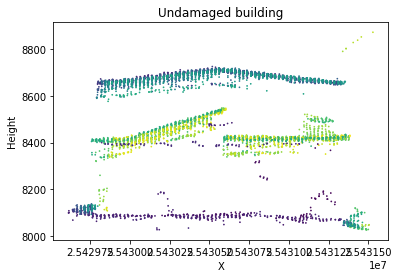

In [ ]:
plt.scatter(build1_pt.X, build1_pt.Z, c=build1_pt.Y , s=0.5)
plt.title("Undamaged building")
plt.ylabel("Height")
plt.xlabel("X")

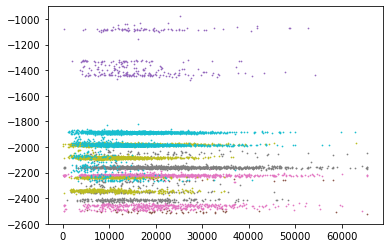

In [ ]:
for b in builds_on_data[45:55]:
  mask = np.array(geogeopoints.within(b))
  pt_build = lidar[mask]
  #floor = np.min(pt_build.Z)
  plt.scatter(pt_build.intensity, pt_build.Z-floor, s=0.5)


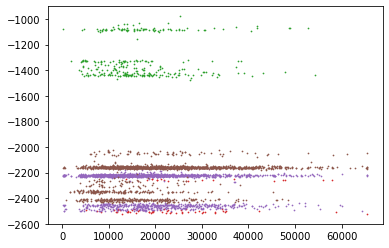

In [ ]:
pts_builds = []
for b in builds_on_data[47:53]:
  mask = np.array(geogeopoints.within(b))
  points = lidar[mask]
  pts_builds.append(points)
  #floor = np.min(pt_build.Z)
  #size = b.area/(len(points)+1)
  plt.scatter(points.intensity, points.Z-floor, s=0.5)


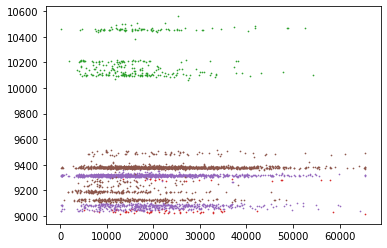

In [ ]:
for pts in pts_builds:
  size = b.area/(len(points)+1)
  plt.scatter(pts.intensity, pts.Z, s=size*size*100)

Measure the density of points

In [ ]:
print(f'Points density of undamaged building ={len(build1_pt)/builds_on_data[442544].area}')

In [ ]:
print(f'Points density of damaged building = {len(build2_pt)/builds_on_data[685650].area}')

Generated links to NOAA Imagery for each building

In [ ]:
for i in builds_on_data.index:
  print(f'\n{i} : https://storms.ngs.noaa.gov/storms/maria/index.html#20/{builds_on_data.centroid.to_crs(4326).y[i]}/{builds_on_data.centroid.to_crs(4326).x[i]}')


442544 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.219465161531613/-65.9199116730476

442545 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.218986107554297/-65.92018999159221

442546 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.218955050001686/-65.9192489000099

536813 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.215137230466173/-65.92001858210888

597770 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.21880849999821/-65.91545819999864

655461 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.215449962135686/-65.91537391568713

655462 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.215306604700874/-65.91537307300624

655463 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.217400025643247/-65.91654950718775

655464 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.2175853235368/-65.91692496182542

655465 : https://storms.ngs.noaa.gov/storms/maria/index.html#20/18.2168218500

In [ ]:
points_on_builds = lidar[np.array(geogeopoints.within(builds_on_data[:15].unary_union))]

685650    POINT (-65.91643 18.21934)
dtype: geometry

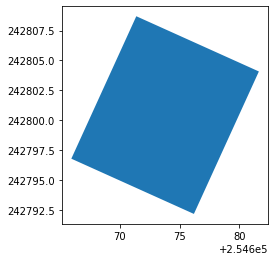

In [ ]:
builds_on_data[49:50].plot()
builds_on_data[49:50].centroid.to_crs(4326)

In [ ]:
print(builds_on_data[442544].centroid)

POINT (254305.8545234032 242813.5673370117)


In [ ]:
fromNAD83.transform(254305.8545234032, 242813.5673370117)

(18.219465161531613, -65.9199116730476)

In [ ]:
geogeopoints.within(builds_on_data[442544])

0          False
1          False
2          False
3          False
4          False
           ...  
5876344    False
5876345    False
5876346    False
5876347    False
5876348    False
Length: 5876349, dtype: bool

---
Coordinates convresion test


In [ ]:
!pip install pyproj

In [ ]:
from pyproj import CRS
#Coordinate reference system from lidar data: (NAD83)
crs_32161 = CRS.from_epsg(32161)
#Coordinate reference system from shapefile: (WSG84/OpenStreetMap)
crs_3857 = CRS.from_epsg(3857)
crs_4326 = CRS.from_epsg(4326)
crs_4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
from pyproj import Transformer

toNAD83 = Transformer.from_crs(crs_4326, crs_32161)
toNAD83

<Concatenated Operation Transformer: pipeline>
Description: Ballpark geographic offset from WGS 84 to NAD83 + SPCS83 Puerto Rico & Virgin Islands zone (meters)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)

In [ ]:
toNAD83 = Transformer.from_crs(crs_3857.geodetic_crs, crs_32161)
toNAD83

<Concatenated Operation Transformer: pipeline>
Description: Ballpark geographic offset from WGS 84 to NAD83 + SPCS83 Puerto Rico & Virgin Islands zone (meters)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)

In [ ]:
fromNAD83 = Transformer.from_crs(crs_32161, crs_4326)
fromNAD83

<Concatenated Operation Transformer: pipeline>
Description: Inverse of SPCS83 Puerto Rico & Virgin Islands zone (meters) + Ballpark geographic offset from NAD83 to WGS 84
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)